# Image segmentation

In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Data preparation

In [2]:
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet

img_size = (128, 128)
num_classes = 3

transform = transforms.Compose([
              transforms.Resize(img_size),
              transforms.ToTensor(),
              transforms.Normalize((0.485, 0.456, 0.406),
                                   (0.229, 0.224, 0.225))
])

# Label preprocessing
def target_transform(target):
    img = transforms.Resize(img_size)(target)
    img = transforms.functional.pil_to_tensor(img).squeeze_()
    img = img - 1
    
    img = img.to(torch.long)
    return img


train_set = OxfordIIITPet(root="pets_data", split="trainval", target_types="segmentation",
                             transform=transform,
                             target_transform=target_transform,
                             download=True)

test_set = OxfordIIITPet(root="pets_data", split="test", target_types="segmentation",
                        transform=transform,
                        target_transform=target_transform,
                        download=True)

In [3]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_set, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=6)
test_loader = DataLoader(test_set, 
                         batch_size=batch_size, 
                         num_workers=6)

In [4]:
def de_normalize(img, 
                 mean=(0.485, 0.456, 0.406), 
                 std=(0.229, 0.224, 0.225)):
    result = img * std + mean
    result = np.clip(result, 0.0, 1.0)
    
    return result

In [5]:
index = 2
test_image = train_set[index][0].numpy().transpose(1,2,0)
test_groundtruth = train_set[index][1]

de_test_image = de_normalize(test_image)
print(de_test_image.min())
print(de_test_image.max())

0.003921562194824202
1.0


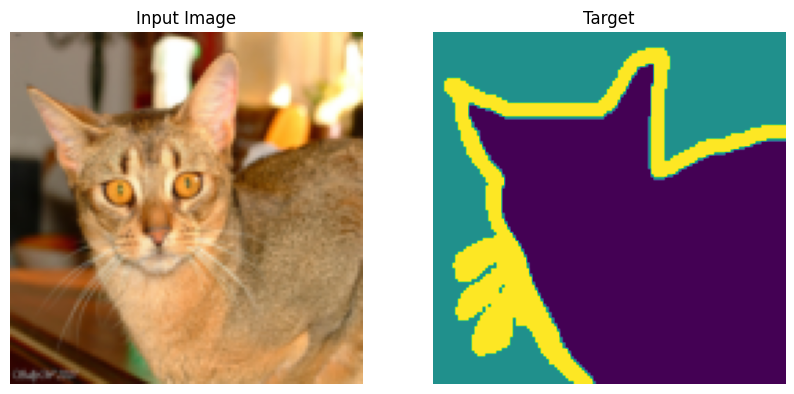

In [6]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Input Image")
plt.imshow(de_test_image)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Target")
plt.imshow(test_groundtruth)

plt.show()

## 2. Model

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size) -> None:
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv_block(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.conv1 = ConvBlock(n_channels, 64, kernel_size=9)
        self.conv2 = ConvBlock(64, 64, kernel_size=9)
        self.conv3 = ConvBlock(64, 64, kernel_size=5)
        self.conv4 = ConvBlock(64, 64, kernel_size=5)
        self.conv5 = ConvBlock(64, 64, kernel_size=5)
        self.conv6 = nn.Conv2d(64, n_classes, kernel_size=3, padding='same')

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        return x

In [10]:
from torchsummary import summary

model = UNet(n_channels=3, n_classes=3).to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          15,616
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         ConvBlock-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]         331,840
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         ConvBlock-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]         102,464
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
        ConvBlock-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]         102,464
      BatchNorm2d-14         [-1, 64, 1

## 3. Train

In [11]:
@torch.inference_mode()
def display_prediction(model, image, target):
    model.eval()
    img = image[None,...].to(device)
    output = model(img)
    pred = torch.argmax(output, axis=1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1,3,1)
    plt.axis('off')
    plt.title("Input Image")
    plt.imshow(de_normalize(image.numpy().transpose(1,2,0)))

    plt.subplot(1,3,2)
    plt.axis('off')
    plt.title("Prediction")
    plt.imshow(pred.cpu().squeeze())

    plt.subplot(1,3,3)
    plt.axis('off')
    plt.title("Ground Truth")
    plt.imshow(target)

    plt.show()

In [12]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

    test_loss = test_loss / len(test_loader)
    return test_loss

In [13]:
max_epoch = 30
LR = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Epoch [1/30], Trainning loss: 0.7769, Test Loss: 0.7802
Test image_80 after epoch 1: 


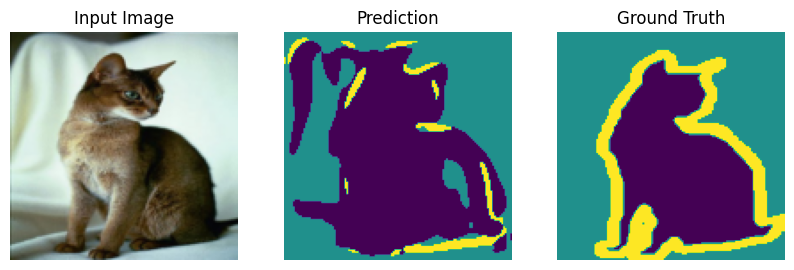

Epoch [2/30], Trainning loss: 0.6809, Test Loss: 0.7617
Test image_80 after epoch 2: 


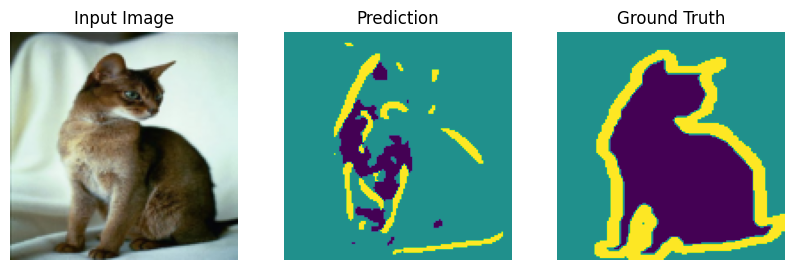

Epoch [3/30], Trainning loss: 0.6504, Test Loss: 0.6654
Test image_80 after epoch 3: 


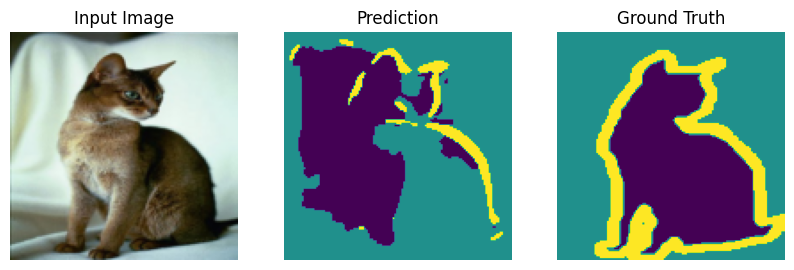

Epoch [4/30], Trainning loss: 0.6242, Test Loss: 0.6489
Test image_80 after epoch 4: 


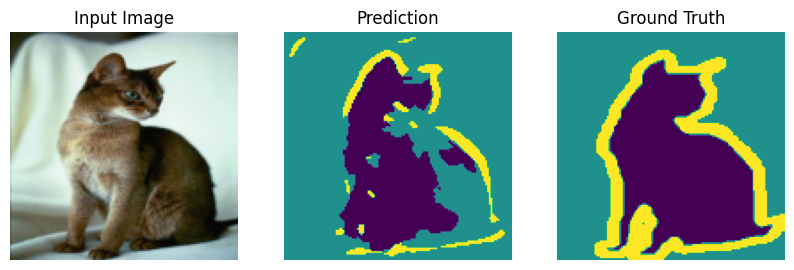

Epoch [5/30], Trainning loss: 0.6099, Test Loss: 0.6108
Test image_80 after epoch 5: 


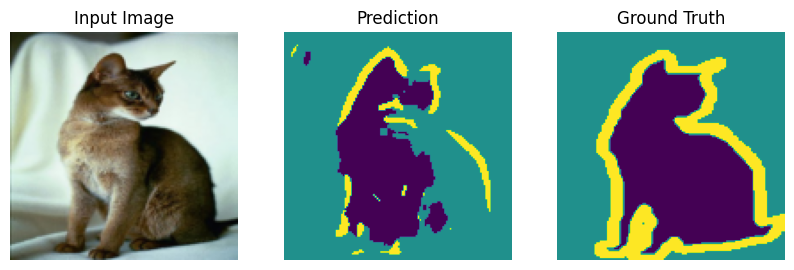

Epoch [6/30], Trainning loss: 0.5982, Test Loss: 0.6725
Test image_80 after epoch 6: 


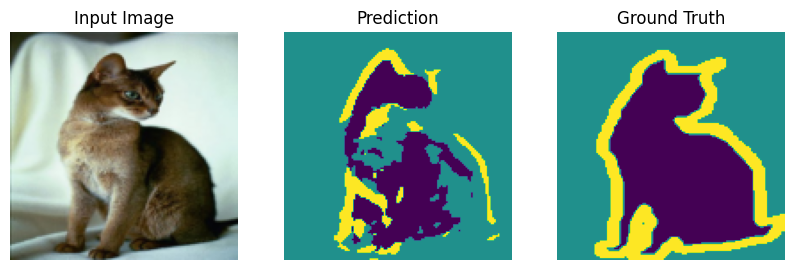

Epoch [7/30], Trainning loss: 0.5852, Test Loss: 0.5743
Test image_80 after epoch 7: 


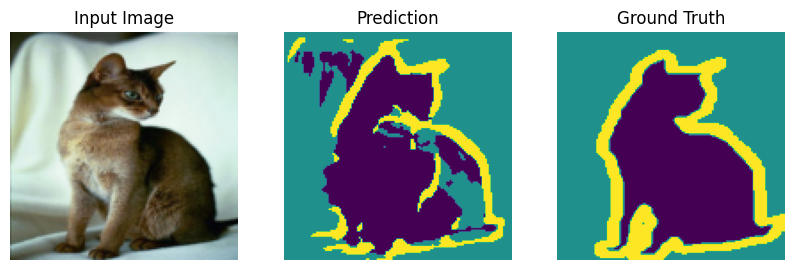

Epoch [8/30], Trainning loss: 0.5604, Test Loss: 0.5975
Test image_80 after epoch 8: 


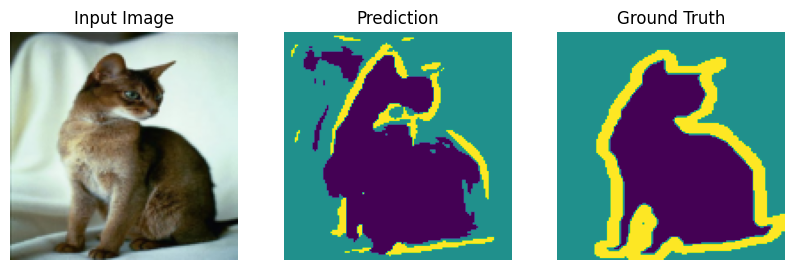

Epoch [9/30], Trainning loss: 0.5551, Test Loss: 0.5925
Test image_80 after epoch 9: 


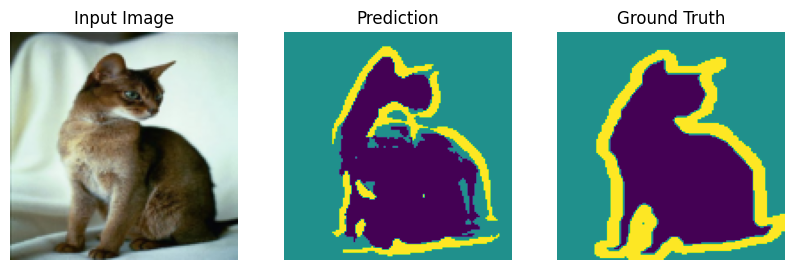

Epoch [10/30], Trainning loss: 0.5550, Test Loss: 0.6000
Test image_80 after epoch 10: 


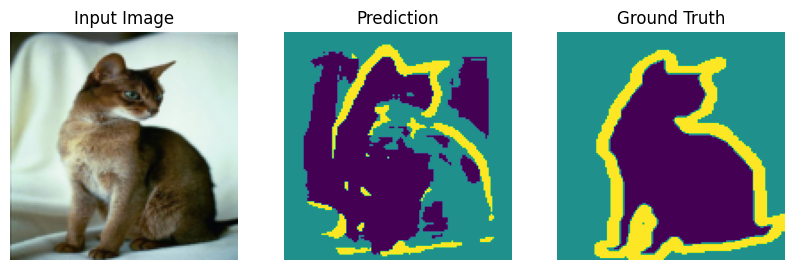

Epoch [11/30], Trainning loss: 0.5489, Test Loss: 0.5854
Test image_80 after epoch 11: 


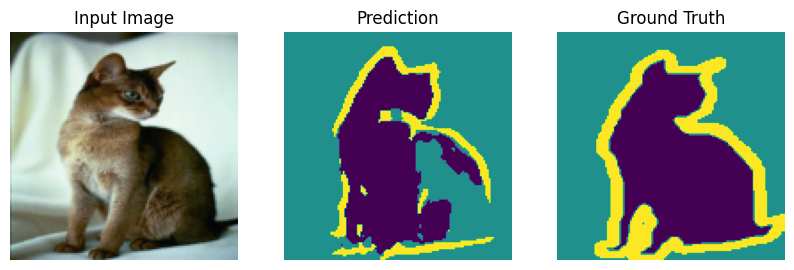

Epoch [12/30], Trainning loss: 0.5417, Test Loss: 0.5477
Test image_80 after epoch 12: 


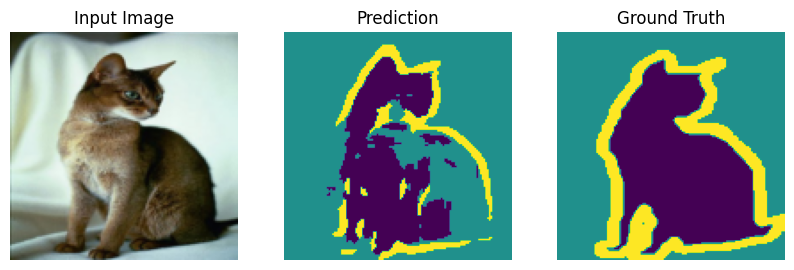

Epoch [13/30], Trainning loss: 0.5298, Test Loss: 0.6557
Test image_80 after epoch 13: 


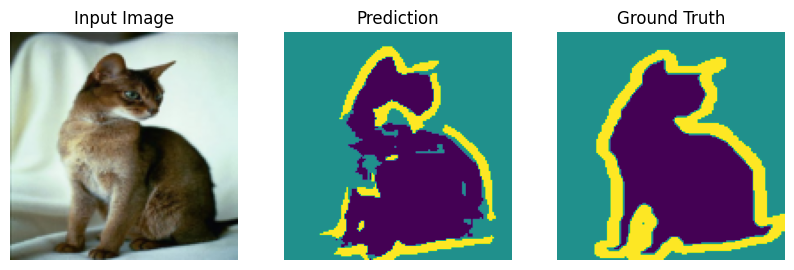

Epoch [14/30], Trainning loss: 0.5331, Test Loss: 0.5458
Test image_80 after epoch 14: 


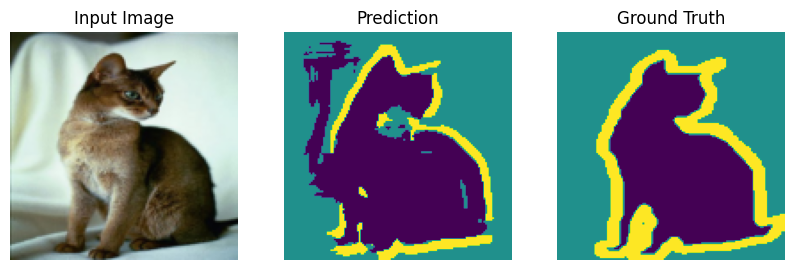

Epoch [15/30], Trainning loss: 0.5204, Test Loss: 0.5162
Test image_80 after epoch 15: 


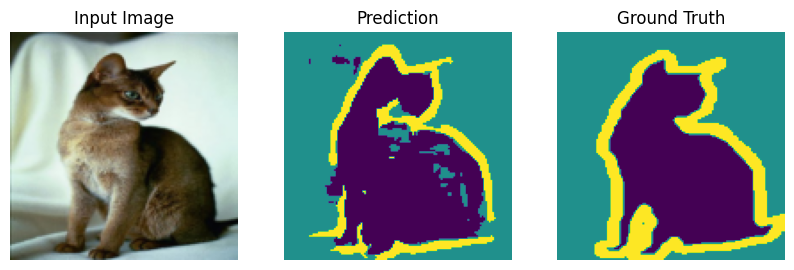

Epoch [16/30], Trainning loss: 0.5172, Test Loss: 0.6863
Test image_80 after epoch 16: 


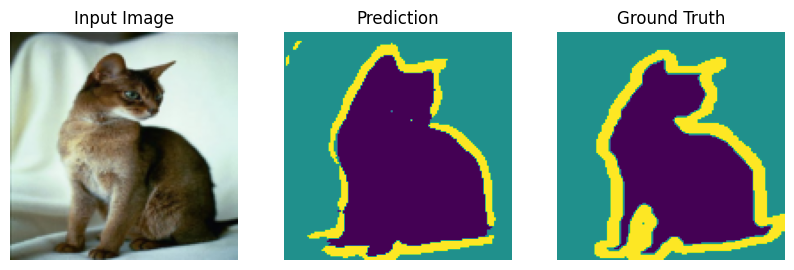

Epoch [17/30], Trainning loss: 0.5141, Test Loss: 0.5438
Test image_80 after epoch 17: 


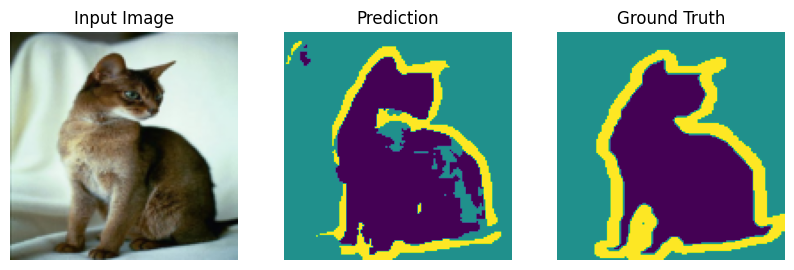

Epoch [18/30], Trainning loss: 0.5085, Test Loss: 0.5245
Test image_80 after epoch 18: 


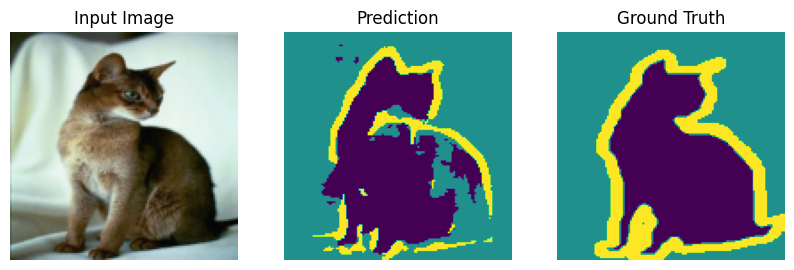

Epoch [19/30], Trainning loss: 0.5088, Test Loss: 0.5815
Test image_80 after epoch 19: 


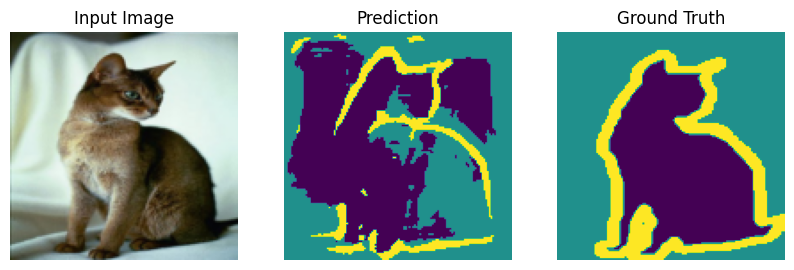

Epoch [20/30], Trainning loss: 0.5040, Test Loss: 0.5211
Test image_80 after epoch 20: 


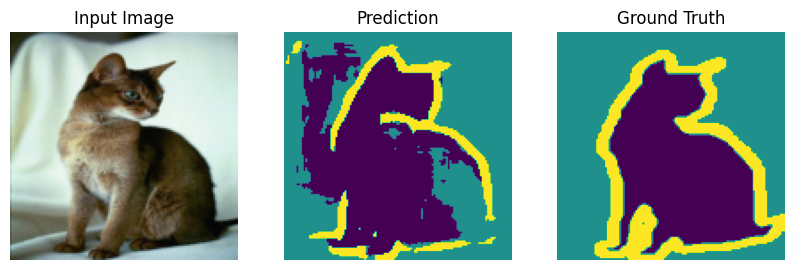

Epoch [21/30], Trainning loss: 0.5071, Test Loss: 0.5298
Test image_80 after epoch 21: 


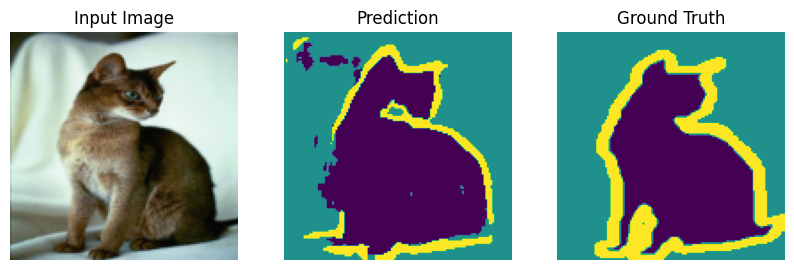

Epoch [22/30], Trainning loss: 0.4947, Test Loss: 0.5577
Test image_80 after epoch 22: 


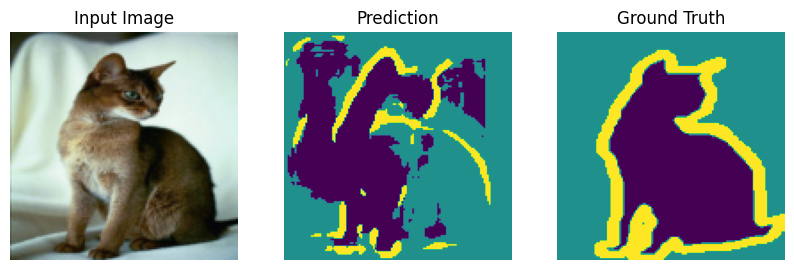

Epoch [23/30], Trainning loss: 0.4950, Test Loss: 0.5300
Test image_80 after epoch 23: 


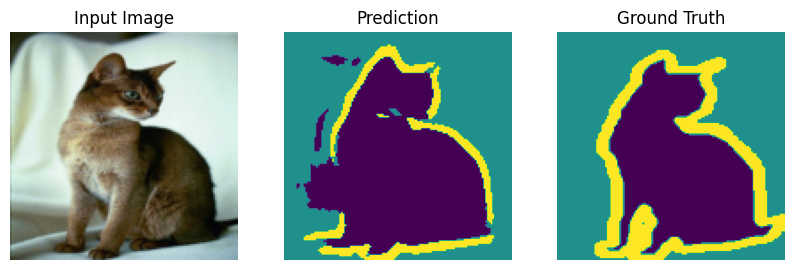

Epoch [24/30], Trainning loss: 0.4944, Test Loss: 0.5118
Test image_80 after epoch 24: 


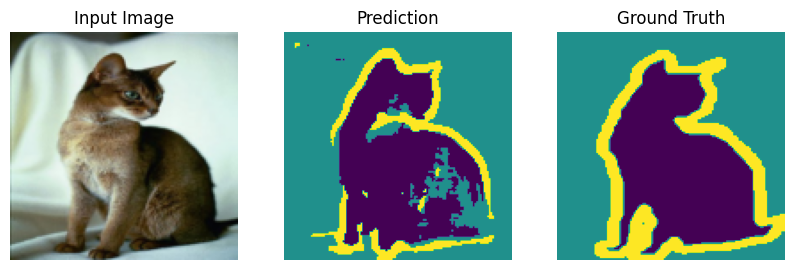

Epoch [25/30], Trainning loss: 0.4900, Test Loss: 0.6656
Test image_80 after epoch 25: 


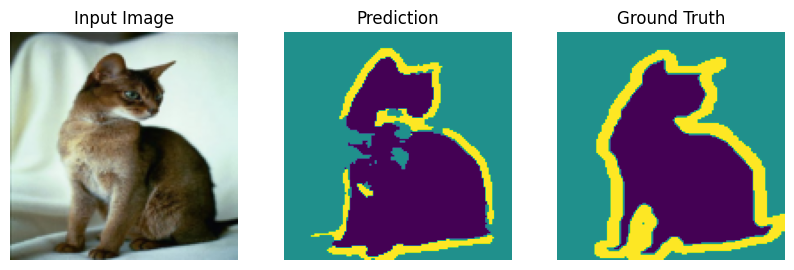

Epoch [26/30], Trainning loss: 0.4884, Test Loss: 0.5006
Test image_80 after epoch 26: 


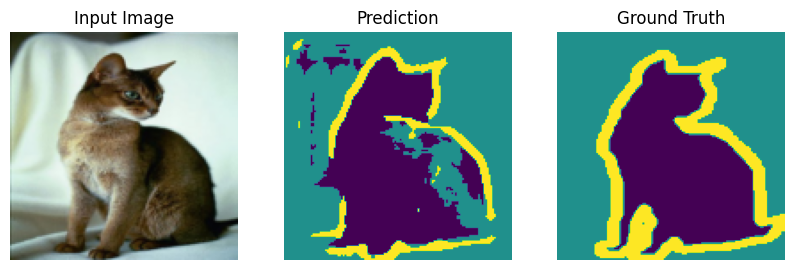

Epoch [27/30], Trainning loss: 0.4841, Test Loss: 0.5208
Test image_80 after epoch 27: 


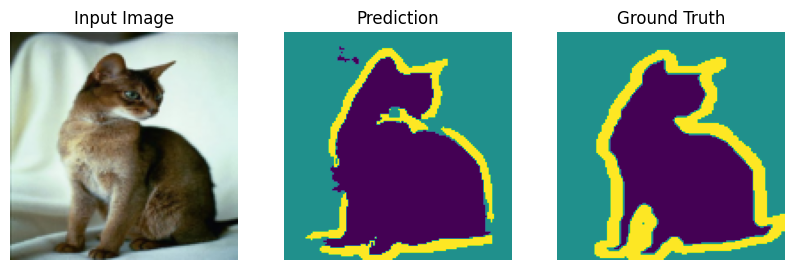

Epoch [28/30], Trainning loss: 0.4863, Test Loss: 0.5858
Test image_80 after epoch 28: 


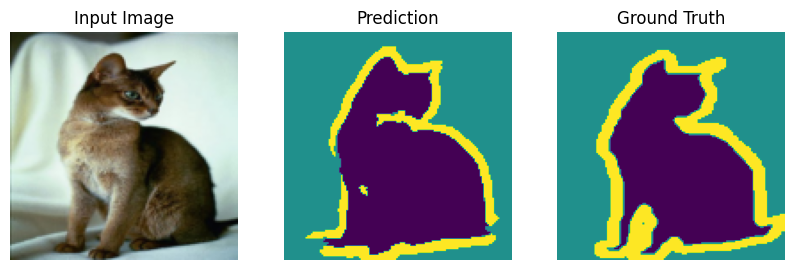

Epoch [29/30], Trainning loss: 0.4771, Test Loss: 0.5278
Test image_80 after epoch 29: 


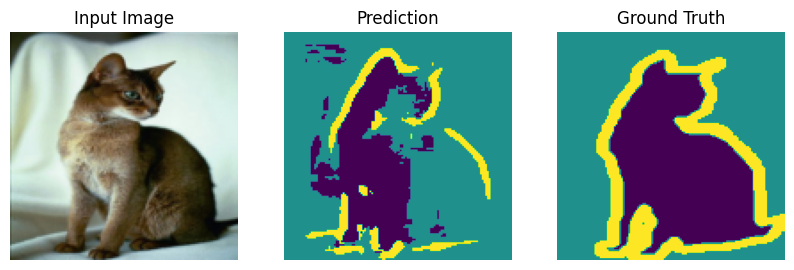

Epoch [30/30], Trainning loss: 0.4803, Test Loss: 0.5417
Test image_80 after epoch 30: 


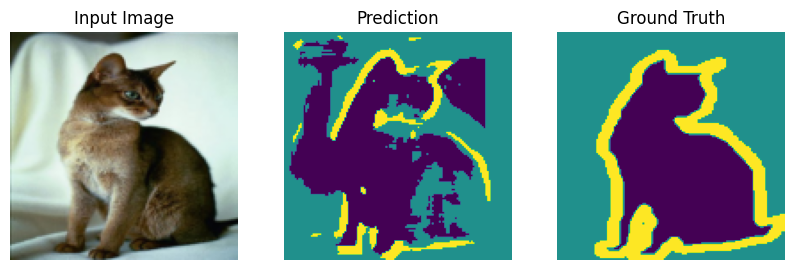

In [14]:
test_index = 80
display_image = test_set[test_index][0]
display_target = test_set[test_index][1]

train_losses = []
test_losses = []
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

model.to(device)
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / len(train_loader)
    test_loss = evaluate(model, test_loader, criterion)
    if test_loss < best_loss:
        best_loss = test_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    print(f"Epoch [{epoch + 1}/{max_epoch}], Trainning loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Test image_{test_index} after epoch {epoch+1}: ")
    display_prediction(model, display_image, display_target)


train_losses.append(epoch_loss)
test_losses.append(test_loss)

In [15]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [16]:
torch.save(model.state_dict(), "2.CNN_segmentation.pt")

## 4. Prediction

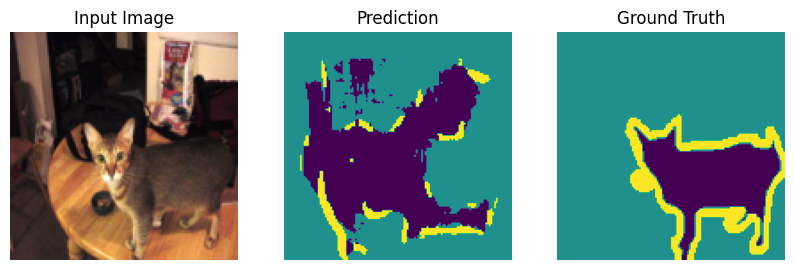

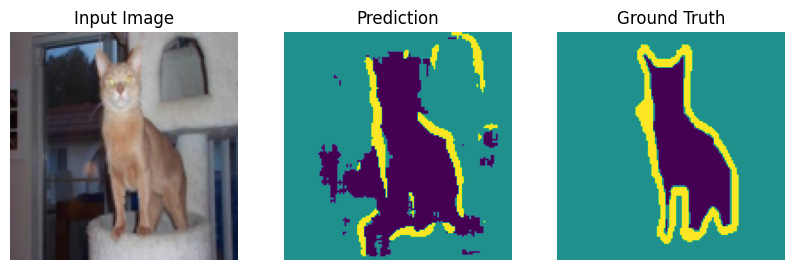

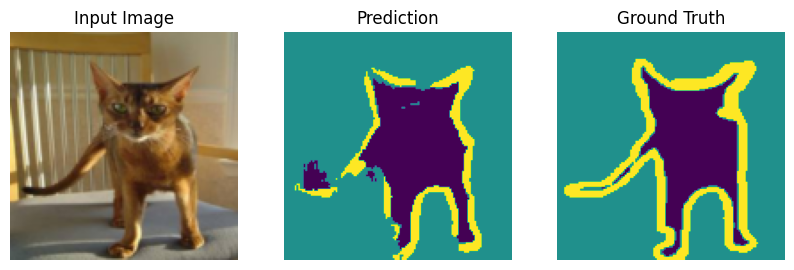

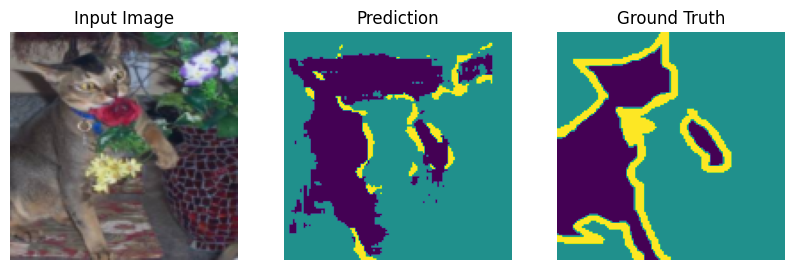

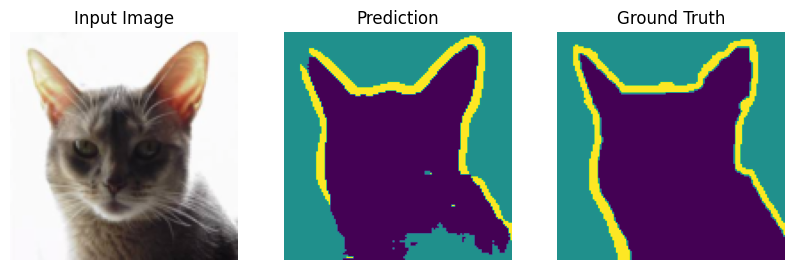

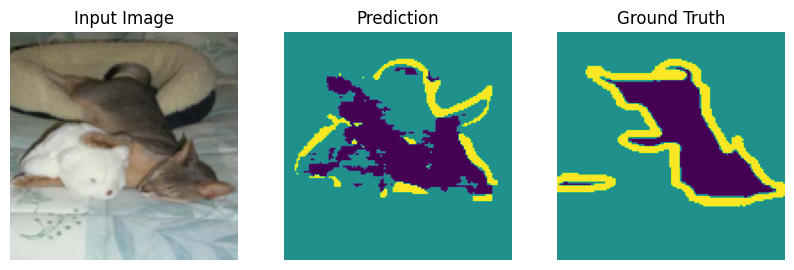

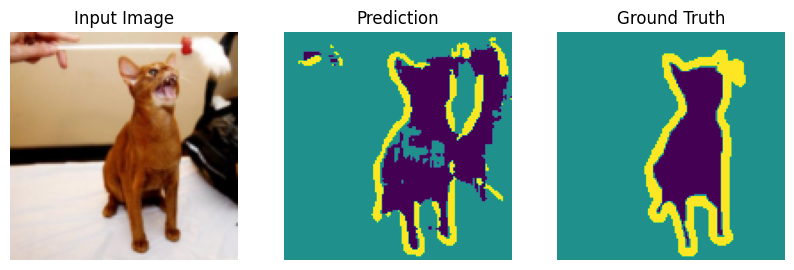

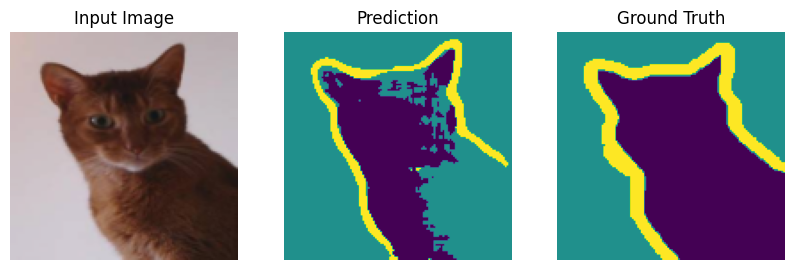

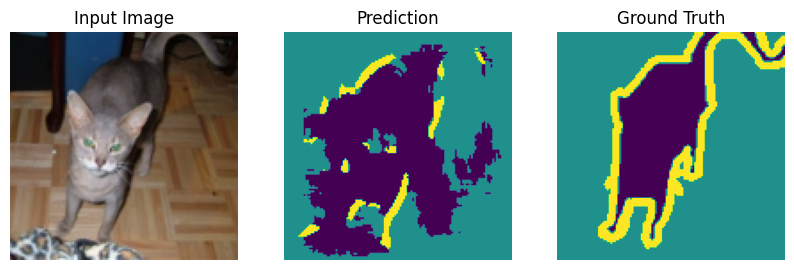

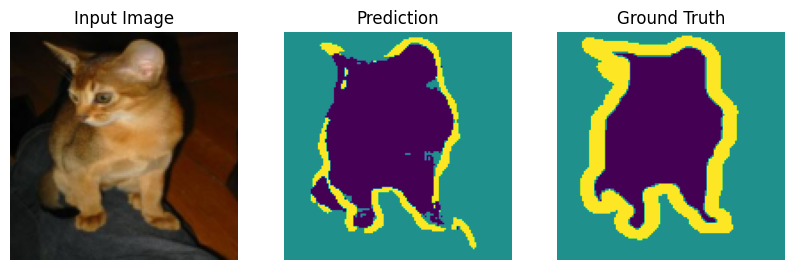

In [17]:
n_test_points = 10

for i in range(n_test_points):
    img, gt = test_set[i]

    display_prediction(model, img, gt)